# Problem 2

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import numpy as np
import matplotlib.pyplot as plt

In [4]:
batch_size = 128
(full_dim, mid_dim, hidden) = (1 * 28 * 28, 1000, 5)
lr = 1e-3
epochs = 100
device = torch.device("cpu")

In [23]:
#####################################
# STEP 2: Define prior distribution #
#####################################

class Logistic(torch.distributions.Distribution):
    def __init__(self):
        super(Logistic, self).__init__(validate_args=False)

    def log_prob(self, x):
        return -(F.softplus(x) + F.softplus(-x))

    def sample(self, size):
        z = torch.distributions.Uniform(0., 1.).sample(size).to(device)
        return torch.log(z) - torch.log(1. - z)

In [24]:
####################################
# STEP 3: Implement Coupling Layer #
####################################

class Coupling(nn.Module):
    def __init__(self, in_out_dim, mid_dim, hidden, mask_config):
        super(Coupling, self).__init__()
        self.mask_config = mask_config
        
        self.in_block = nn.Sequential(nn.Linear(in_out_dim//2, mid_dim), nn.ReLU())
        self.mid_block = nn.ModuleList([nn.Sequential(nn.Linear(mid_dim, mid_dim), nn.ReLU())
                                                                 for _ in range(hidden - 1)])
        self.out_block = nn.Linear(mid_dim, in_out_dim//2)

    def forward(self, x, reverse=False):
        [B, W] = list(x.size())
        x = x.reshape((B, W//2, 2))
        if self.mask_config:
            on, off = x[:, :, 0], x[:, :, 1]
        else:
            off, on = x[:, :, 0], x[:, :, 1]

        off_ = self.in_block(off)
        for i in range(len(self.mid_block)):
            off_ = self.mid_block[i](off_)
        shift = self.out_block(off_)
        
        if reverse:
            on = on - shift
        else:
            on = on + shift

        if self.mask_config:
            x = torch.stack((on, off), dim=2)
        else:
            x = torch.stack((off, on), dim=2)
        return x.reshape((B, W))

class Scaling(nn.Module):
    def __init__(self, dim):
        super(Scaling, self).__init__()
        self.scale = nn.Parameter(torch.zeros((1, dim)), requires_grad=True)

    def forward(self, x, reverse=False):
        log_det_J = torch.sum(self.scale)
        if reverse:
            x = x * torch.exp(-self.scale)
        else:
            x = x * torch.exp(self.scale)
        return x, log_det_J

In [25]:
##########################
# STEP 4: Implement NICE #
##########################

class NICE(nn.Module):
    def __init__(self,in_out_dim, mid_dim, hidden, mask_config=1.0, coupling=4):
        super(NICE, self).__init__()
        self.prior = Logistic()
        self.in_out_dim = in_out_dim

        self.coupling = nn.ModuleList([
            Coupling(in_out_dim=in_out_dim, 
                     mid_dim=mid_dim, 
                     hidden=hidden, 
                     mask_config=(mask_config+i)%2) \
            for i in range(coupling)])
        
        self.scaling = Scaling(in_out_dim)

    def g(self, z):
        x, _ = self.scaling(z, reverse=True)
        for i in reversed(range(len(self.coupling))):
            x = self.coupling[i](x, reverse=True)
        return x

    def f(self, x):
        for i in range(len(self.coupling)):
            x = self.coupling[i](x)
        z, log_det_J = self.scaling(x)
        return z, log_det_J

    def log_prob(self, x):
        z, log_det_J = self.f(x)
        log_ll = torch.sum(self.prior.log_prob(z), dim=1)
        return log_ll + log_det_J

    def sample(self, size):
        z = self.prior.sample((size, self.in_out_dim)).to(device)
        return self.g(z)

    def forward(self, x):
        return self.log_prob(x)

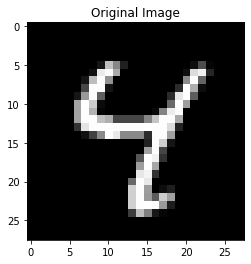

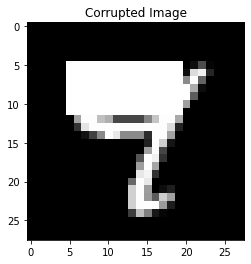

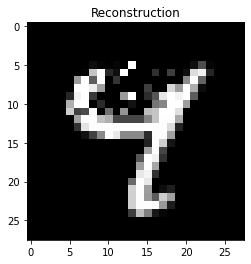

In [45]:
# Load pre-trained NICE model onto CPU
model = NICE(in_out_dim=784, mid_dim=1000, hidden=5).to(device)
model.load_state_dict(torch.load('nice.pt',map_location=torch.device('cpu')))

# Since we do not update model, set requires_grad = False
model.requires_grad_(False)

# Get an MNIST image
testset = torchvision.datasets.MNIST(root='./', train=False, download=True, transform=torchvision.transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)
pass_count = 6
itr = iter(test_loader)
for _ in range(pass_count+1):
    image,_ = itr.next()

plt.figure(figsize = (4,4))
plt.title('Original Image')
plt.imshow(make_grid(image.squeeze().detach()).permute(1,2,0))
# plt.show()
plt.savefig('plt1.png')


# Create mask 
mask = torch.ones_like(image,dtype=torch.bool)
mask[:,:,5:12,5:20] = 0

# Partially corrupt the image
image[mask.logical_not()] = torch.ones_like(image[mask.logical_not()])
plt.figure(figsize = (4,4))
plt.title('Corrupted Image')
plt.imshow(make_grid(image.squeeze()).permute(1,2,0))
# plt.show()
plt.savefig('plt2.png')


lr = 1e-3
recon = image.clone().requires_grad_(True)

for i in range(300):
    loss = -model(recon.view(-1, 784))
    loss.backward()
    recon.data[mask.logical_not()] -= lr * recon.grad[mask.logical_not()]
    recon.data[mask.logical_not()] = torch.clamp(recon.data[mask.logical_not()], min = 0.0, max = 1.0)

# Plot reconstruction
plt.figure(figsize = (4,4))
plt.title('Reconstruction')
plt.imshow(make_grid(recon.squeeze().detach()).permute(1,2,0))
# plt.show()
plt.savefig('plt3.png')

# Problem 4

In [60]:
import numpy as np
from matplotlib import pyplot as plt
import math

In [86]:
N, p = 30, 20
np.random.seed(0)
X = np.random.randn(N,p)
Y = 2*np.random.randint(2, size = N) - 1
lamda = 30

theta = 0.1 * np.random.randn(p)
phi = 0.1 * np.random.randn(p)
alpha = 3e-1
beta = 1e-4

In [87]:
epoch = 1000
L_val = []
d_phi_val = []
d_theta_val = []

for _ in range(epoch):
    for _ in range(N):
        i = np.random.randint(N)
        d_phi = Y[i] / (1 + np.exp(Y[i] * ((X[i,:]-phi) @ theta))) * theta - lamda * phi
        phi += beta * d_phi
        d_theta = ( -Y[i] / (1 + np.exp(Y[i] * ((X[i,:]-phi) @ theta))) )*(X[i,:]-phi)
        theta -= alpha * d_theta

    L_i = np.average(np.log(1 + np.exp(-Y * ((X - phi.reshape(1,-1)) @ theta)))) - lamda/2 * np.linalg.norm(phi, axis=0, ord=2) **2
    d_phi = np.average(Y / (1 + np.exp(Y * ((X-phi.reshape(1,-1)) @ theta)))) * theta - lamda * phi
    d_theta = np.average(( -Y / (1 + np.exp(Y * ((X-phi.reshape(1,-1)) @ theta))) ).reshape(-1,1)*(X-phi.reshape(1,-1)), axis=0)
    
    L_val.append(L_i)
    d_phi_val.append(d_phi)
    d_theta_val.append(d_theta)

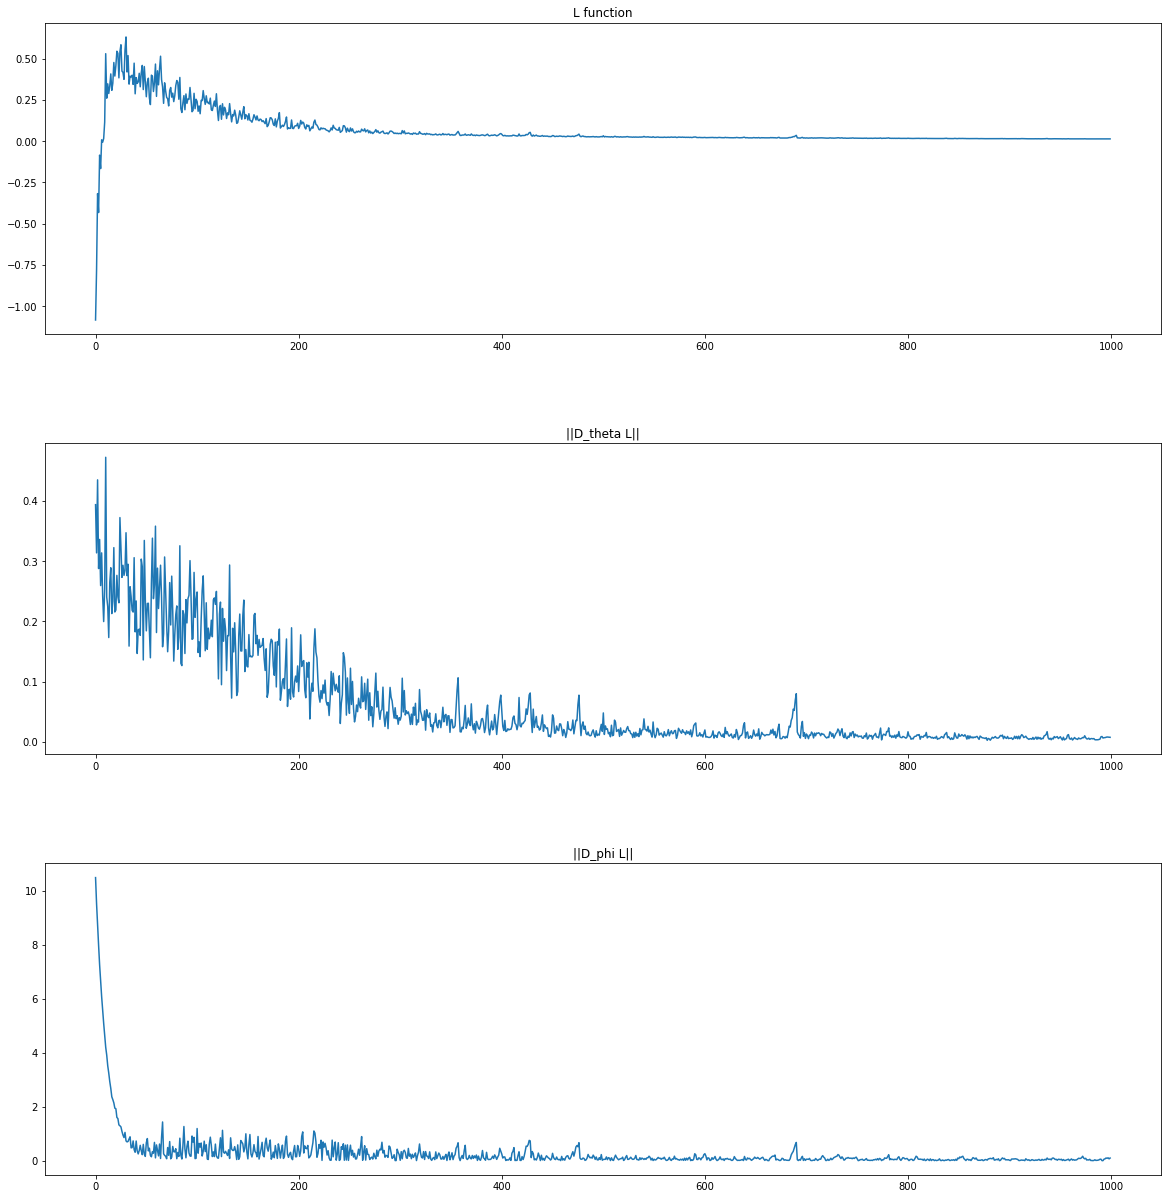

In [88]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.subplots_adjust(left=0.125,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.35)
plt.subplot(3, 1, 1)
plt.title("L function")
plt.plot(L_val)
plt.subplot(3, 1, 2)
plt.title("||D_theta L||")
plt.plot(np.linalg.norm(d_theta_val, axis=1, ord=2))
plt.subplot(3, 1, 3)
plt.title("||D_phi L||")
plt.plot(np.linalg.norm(d_phi_val, axis=1, ord=2))
plt.show()